# Machine Translation Using PyTorch -- French to English
by Hanna Seyoum

## II. Milestone Report

### 1. Problem Statement
There are plenty of machine translators, some with high accuracy, and others with much needed improvement. I want to build a machine translator with high accuracy, starting with english-french translations, to eventually build translators for less popular languages such as Amharic.

### 2. Data Acquisition and Loading
I downloaded the data which is a zip file from manythings.org/anki. I used the module `zipfile` to find the .zip file and extract the .txt file that contained the data. I then opend the file and read it. Since each line contained a sentence pair of english and french text, and additional information, I split the data by linebreaks. And in each line, the english and french phrases were separated by a tab, so I separated them by tab and created a dataframe with two columns.

### 3. Methodology
**Data cleaning:**
The sentence pairs were tab-delimited, separated by a tab, so once I loaded the data, I iterated over each row and split it up by tab. This resulted in 178,009 rows with 3 blocks which I saved as a list. First block had the english phrases, second block had french phrases, and third block had information on the phrases. I then changed this list to a dataframe, with the first block as the first column, second block as the second column, and deleted the third block since it was irrelevant to the task at hand.

**Data preprocessing:**
I first defined a function, `unicode_to_ascii`, to normalize the unicode data. Then defined a function, `preprocess_sentence`, that first applies the unicode_to_ascii function to each row and changes each letter to small cases and strips white spaces. Then function then tokenizes each phrase by replacing all punctuations with spaces except for sentence ending punctuations. It also adds the `<start>` and `<end>` tokens at the begining and ending of each phrase.

**Missing values:**  
There were no missing values.

**Outliers:**  
There were no outliers.

### 4. Initial Findings

Phrase Distribution: [phrase-dist](#Phrase-Distribution)  
We see that the distribution of number of english words per phrase is nearly normally distributed, while the french distribution is skewed to the right. This tells us that in general, french phrases tend to have more words that english phrases. 
    
Phrase Statistics: [phrase-stat](#Phrase-Statistics)  
* 112079 English words in total
* 129852 French words in total
* Avg number of English words per phrase: 0.7 | standard deviation: -2.2
* Avg number of French words per phrase: 1.3 | standard deviation: -1.6
* Number of English words per phrase | minimum: 1, maximum: 7
* Number of French words per phrase | minimum: 1, maximum: 14

Word Distribution: [word-dist](#Word-Distribution)  
We see that the distribution of number of characters per word is nearly normally distributed for both english and french.

Word Statistics: [word-stat](#Word-Statistics)  
* Avg number of English characters per word: 6.2 | standard deviation: 2.1
* Avg number of French characters per word: 7.1 | standard deviation: 2.2
* Number of English characters per word | minimum: 1, maximum: 15
* Number of French characters per word | minimum: 1, maximum: 16

### 5. Statistical Analysis - Zipf's Law

Zipf's law is one of the most well-known laws in quantiative linguistics.
* It's a very simple power law. It relates the rank ($r$) of an ordered list item to the frequency of occurence ($p_{i}$) for this item:  
    $p_{i} = \frac{1}{i_{a}}$ => log$(p_{i})$ = $-a$log$(i)$, with $a \approx 1$
        
* It's validity has been observed in a wide range of phenomena, including natural languages, finance, ecological systems, and web statistics.

In this section, I calculate word frequencies of both english and french texts, calculate their ranks, and plot their scatterplots with logarithmic scales. Both plots show that the ranks of frequency of words follow the Zipf's law. We have the ranks on the x-axis, and the word frequencies on the y-axis. The least frequent words have the highest ranks, while the most frequent words have the lowest ranks. If the plots were not on a logarithmic scale, we would notice the  significant drop in word frequencies between the first few ranks, and the rank continues to reduce.

You can see the plots here: [Zipf Plot](#Zipf's-Plot) 

### 6. Libraries & Packages
**Required packages:**  
* Used Anaconda to download necessary packages
* Installed Pytorch in addition to the packages automatically installed through anaconda

**Required libraries:**
* Pandas: for data analysis
* NumPy: for working with arrays
* Matplotlib: for data visualization
* re: for regular expression

### 7. Code

### Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")

### Dataset:  Bilingual Sentence pairs
Download [manythings.org/anki/fra-eng.zip](http://www.manythings.org/anki/fra-eng.zip)

In [2]:
from zipfile import ZipFile
with ZipFile('../Capstone-Project-2/data/fra-eng.zip', 'r') as zipobj:
   # Get a list of all archived file names from the zip
   # filenames = zipobj.namelist()
   zipobj.extract('fra.txt')

In [3]:
lines = open('fra.txt', encoding='UTF-8').read().strip().split('\n')

In [4]:
# sample size (try with smaller sample size to reduce computation)
num_examples = 30000 

# creates lists containing each pair
original_word_pairs = [[w for w in l.split('\t')] for l in lines[:num_examples]]

In [5]:
data = pd.DataFrame(original_word_pairs, columns=["eng", "fr", "info"])
data = data.drop(columns="info", axis=1)

In [6]:
data.head(5)

,eng,fr
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [7]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    """
    Normalizes latin chars with accent to their canonical decomposition
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    """
    tokenize a phrase by replacing all punctuations with spaces except for sentence ending punctuations.
    also adds the <start> and <end> token
    """
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

### Building Vocabulary Index

In [8]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        """ lang are the list of phrases from each language"""
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            # update with individual tokens
            self.vocab.update(phrase.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word        

### Data Exploration & Visualization

In [9]:
# checking for missing values
data.isna().sum()

eng    0
fr     0
dtype: int64

In [10]:
# Now we do the preprocessing using pandas and lambdas
data["eng"] = data.eng.apply(lambda w: preprocess_sentence(w))
data["fr"] = data.fr.apply(lambda w: preprocess_sentence(w))
data.sample(10)

,eng,fr
13463,<start> you re demented . <end>,<start> tu es fou . <end>
16341,<start> stay out of this . <end>,<start> restez en dehors de ca ! <end>
4349,<start> someone came . <end>,<start> quelqu un est venu . <end>
4098,<start> is it an elk ? <end>,<start> est ce un elan ? <end>
20170,<start> is the water deep ? <end>,<start> l eau est elle profonde ? <end>
11713,<start> i m very hungry . <end>,<start> j ai les crocs . <end>
15721,<start> it may rain soon . <end>,<start> il devrait pleuvoir bientot . <end>
9863,<start> you were great . <end>,<start> tu as ete super . <end>
4899,<start> are they busy ? <end>,<start> sont ils occupees ? <end>
8044,<start> i have an idea . <end>,<start> j ai une idee . <end>


In [11]:
# index language using the class above
inp_lang = LanguageIndex(data["fr"].values.tolist())
targ_lang = LanguageIndex(data["eng"].values.tolist())

#### Phrase Statistics

In [12]:
# phrase stats
data_stats = data.copy()

def word_count(phrase):
    return len(phrase.split())-3

data_stats['eng_word_count'] = data_stats["eng"].apply(lambda x: word_count(x))
data_stats['fr_word_count'] = data_stats["fr"].apply(lambda x: word_count(x))

avg_eng_words_per_phrase = round(np.mean(data_stats['eng_word_count'])-3, 1)
avg_fr_words_per_phrase = round(np.mean(data_stats['fr_word_count'])-3, 1)
std_eng_words_per_phrase = round(np.std(data_stats['eng_word_count'])-3, 1)
std_fr_words_per_phrase = round(np.std(data_stats['fr_word_count'])-3, 1)

print("phrase statistics:\n")
print('{} English words in total'.format(data_stats['eng_word_count'].sum()) ) 
print('{} French words in total'.format(data_stats['fr_word_count'].sum()) )
print("Avg number of English words per phrase: {} | standard deviation: {}".format(avg_eng_words_per_phrase, std_eng_words_per_phrase))
print("Avg number of French words per phrase: {} | standard deviation: {}".format(avg_fr_words_per_phrase, std_fr_words_per_phrase))
print("Number of English words per phrase | minimum: {}, maximum: {}".format(min(data_stats["eng_word_count"]), max(data_stats["eng_word_count"])))
print("Number of French words per phrase | minimum: {}, maximum: {}".format(min(data_stats["fr_word_count"]), max(data_stats["fr_word_count"])))

phrase statistics:

112079 English words in total
129852 French words in total
Avg number of English words per phrase: 0.7 | standard deviation: -2.2
Avg number of French words per phrase: 1.3 | standard deviation: -1.6
Number of English words per phrase | minimum: 1, maximum: 7
Number of French words per phrase | minimum: 1, maximum: 14


#### Phrase Distribution

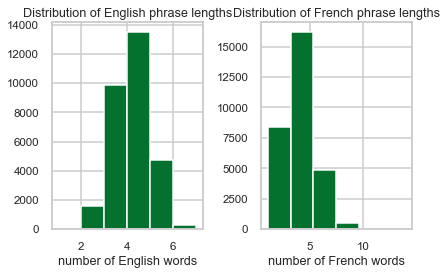

In [13]:
plt.subplot(1,2,1)
plt.hist(data_stats["eng_word_count"], bins=6)
plt.xlabel("number of English words")
plt.title("Distribution of English phrase lengths")

plt.subplot(1,2,2)
plt.hist(data_stats["fr_word_count"], bins=6)
plt.xlabel("number of French words")
plt.title("Distribution of French phrase lengths")

plt.tight_layout()
plt.show()

#### Word Statistics

In [14]:
# words stats

eng_char_lengths = [len(word) for word in list(targ_lang.idx2word.values())]
fr_char_lengths = [len(word) for word in list(inp_lang.idx2word.values())]

print("word statistics:\n")
print("Avg number of English characters per word: {} | standard deviation: {}".format(round(np.mean(eng_char_lengths), 1), round(np.std(eng_char_lengths), 1)))
print("Avg number of French characters per word: {} | standard deviation: {}".format(round(np.mean(fr_char_lengths), 1), round(np.std(fr_char_lengths), 1)))
print("Number of English characters per word | minimum: {}, maximum: {}".format(min(eng_char_lengths), max(eng_char_lengths)))
print("Number of French characters per word | minimum: {}, maximum: {}".format(min(fr_char_lengths), max(fr_char_lengths)))

word statistics:

Avg number of English characters per word: 6.2 | standard deviation: 2.1
Avg number of French characters per word: 7.1 | standard deviation: 2.2
Number of English characters per word | minimum: 1, maximum: 15
Number of French characters per word | minimum: 1, maximum: 16


#### Word Distribution

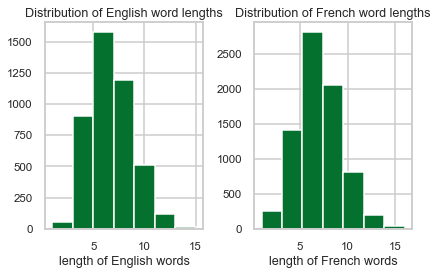

In [15]:
plt.subplot(1,2,1)
plt.hist(eng_char_lengths, bins=7)
plt.xlabel("length of English words")
plt.title("Distribution of English word lengths")

plt.subplot(1,2,2)
plt.hist(fr_char_lengths, bins=7)
plt.xlabel("length of French words")
plt.title("Distribution of French word lengths")
plt.tight_layout()
plt.show()

In [16]:
# Export English and French columns as .txt files

df_english = data["eng"].astype('|S')
df_french = data["fr"].astype('|S')

In [17]:
# inside the open parenthesis, insert a path for where you want the .txt files to be stored. 

with open('../Capstone-Project-2/data/english.txt', 'a') as f:
    f.write(df_english.to_string(header=False, index=False))
    
with open('../Capstone-Project-2/data/french.txt', 'a') as f:
    f.write(df_french.to_string(header=False, index=False))

In [18]:
# open the files saved in the previous cell
open_file = open('../Capstone-Project-2/data/english.txt', 'r')
eng_file_to_string = open_file.read()
eng_words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', eng_file_to_string)

eng_frequency = {}
#english -- build dict of words based on frequency
for word in eng_words:
    count = eng_frequency.get(word,0)
    eng_frequency[word] = count + 1

#-----------------------------------------------------

open_file = open('../Capstone-Project-2/data/french.txt', 'r')
fr_file_to_string = open_file.read()
fr_words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', fr_file_to_string)

fr_frequency = {}
#french -- build dict of words based on frequency
for word in fr_words:
    count = fr_frequency.get(word,0)
    fr_frequency[word] = count + 1

#### Zipf's Plot

In [19]:
def dict_to_df(lang_dict):
    """ changing english and french word frequency dictionaries into series',
    and converting them to dataframes"""
    
    s = pd.Series(lang_dict)
    df  = pd.DataFrame()
    df['word_frequency'] = s
    df = df.sort_values('word_frequency')
    return df

def zipf_plot(lang_dict):
    """
    change dictonary containig each word as the key and their frequencies as their values into a series.
    create a dataframe out of the series, and name the column containing word frequencies word_frquency.
    count the number of each value in the word_frequency column.
    
    """
    # changing dictonary containig each word as the key and their frequencies as their values into a series, 
    # then returning as a dataframe
    
    df = dict_to_df(lang_dict)
    
    word_frequency_counts = df['word_frequency'].value_counts()
    df = pd.DataFrame()
    df["word_frequency_counts"] = word_frequency_counts
    df["rank"] = range(1, len(df)+1)
    df.plot(kind="scatter", x='rank', y='word_frequency_counts', logx=True, logy=True)

Text(0.5, 1.0, 'Zipf Plot of French Words')

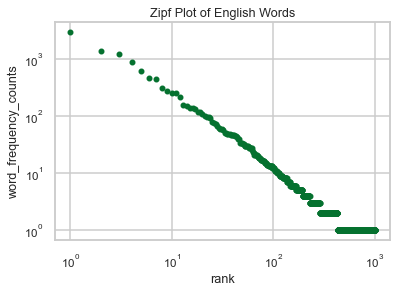

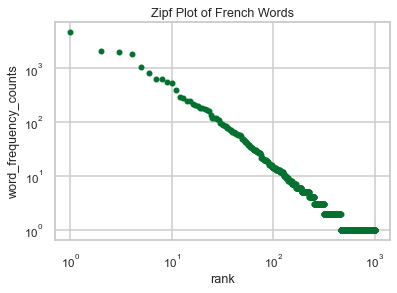

In [20]:
#codes to remove 'c' argument error the error
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

zipf_plot(eng_frequency)
plt.title("Zipf Plot of English Words")

zipf_plot(fr_frequency)
plt.title("Zipf Plot of French Words")